# Résolution d'un problème de flexion d'un poteau par éléments finis - Modèle de Timoshenko
Exemple vu en ED éléments finis - Mécanique des solides déformations 

@Arts et Métiers - Campus de Bordeaux

## Choix d’une modélisation
On souhaite étudier la tenue mécanique d’un poteau en acier (S185 galvanisé) soumis à l'action du vent.
Ce poteau fait une hauteur H. Il est tubulaire : sa section droite est circulaire et creuse, de rayon extérieur r et d’épaisseur e constants.

L'action du vent est modélisée par un efort linéique à ditribution linéaire : .
$\vec{f_l} = \frac{f_l}{H}x \vec{y}$ .
La liaison entre le poteau et le sol est modélisée par un encastrement.

On suppose que le matériau est homogène et isotrope. Ses propriétés élastiques sont données par le module d’Young $E$, le coefficient de Poisson $\nu$, et la limite d’élasticité $Re$. Sa masse volumique est notée $\rho$.
Le cadre d’application est celui des Petites Perturbations.

Données : $H$ = 5m, $r$ = 15cm, $e$ = 5mm, $E$ = 210GPa, $\nu$ = 0.285, $Re$ = 185MPa, $\rho$ = 7850kg/m3.

Remarque : 
* Dans le code, certains paramètres sont définis comme des fonctions pour pouvoir les remplacer par des valeurs variables le long de la poutre. 
* Plusieurs conditions de chargement ont été prédéfinies. Le cas de chargement peut être modifié en changeant la variable 'LoadCondition'.


In [21]:
import numpy as np
from matplotlib import pylab as plt

H = 5
E = 210e9 #Young Modulus
nu = 0.285 #poisson Ratio
F = -1000 #point force at the high end of the beam

# the following function are given in function of the global coordinate x
def r(x): return 0.15 # Constant section radius
#def r(x): return 0.20*(1-x/H)+ 0.10*x/H # Variale section radius
def e(x): return 0.005 #Section thickness
def S(x): return np.pi * (r(x)**2 - (r(x)-e(x))**2)  #Section Area
def I(x): return np.pi/4 * (r(x)**4 - (r(x)-e(x))**4)  #Section Area

LoadCondition = 1
if LoadCondition == 0:
    #Constant lineic force    
    F = 0
    def fl(x): return -100 #lineic force 
elif LoadCondition == 1: 
    #Variable lineic force (with constant derivative)
    F = 0
    def fl(x): 
        a = 100/H ; b = 0
        return a*x+b
elif LoadCondition == 2: 
    F=1000 #point force at the high end of the beam
    #node force on the top extremity
    def fl(x): return 0        


## Choix d'une discrétisation
Afin de résoudre ce problème par la méthode des éléments finis, on choisit de discrétiser la poutre ci-dessus en 3 éléments de longueur L identiques : poutres à deux nœuds avec 2 degrés de liberté par noeud (déplacement $v$ suivant $y$ et rotation $\theta$ suivant $\vec{z}$).
Il y aura ainsi 4 noeuds au total. La position des noeuds suivant $\vec{x}$ est déterminé avec la fonction linspace de numpy.

In [22]:
xmin = 0
xmax = H
NumberOfElements = 3

TypeElement = 'Beam2' #can be modified to 'Beam3' or 'Beam2+'

if TypeElement == 'Beam2' or TypeElement =='Beam2+': NumberOfNodes = NumberOfElements + 1
elif TypeElement == 'Beam3': 
    NumberOfNodes = 2*NumberOfElements + 1
else: raise NameError('TypeElement should be Beam2 or Beam3')
       
NodeCoordinates = np.linspace(xmin,xmax,NumberOfNodes)
print(NodeCoordinates)

[0.         1.66666667 3.33333333 5.        ]


Pour définir les 3 éléments, il convient de créer une matrice de connection dont les lignes sont les numéros des noeuds appartenant aux éléments (nombre de lignes = nombre d'éléments)

In [23]:
if TypeElement == 'Beam2' or TypeElement =='Beam2+':
    ConnectionMatrix = np.c_[(np.arange(NumberOfNodes-1), np.arange(1,NumberOfNodes))]
elif TypeElement == 'Beam3':
    ConnectionMatrix = np.c_[(np.arange(0,NumberOfNodes-2,2), np.arange(1,NumberOfNodes-1,2),np.arange(2,NumberOfNodes,2))]
    
print(ConnectionMatrix)

[[0 1]
 [1 2]
 [2 3]]


## Champs de déplacement de déformation et de contraintes approchés 
### Interpolation du champ de déplacement
Pour la méthode des éléments finis, il faut commencer par définir une fonction d'interpolation sur chaque élément.
Pour un élément poutre basé sur le modèle de Timoshenko il faut définir une interpolation pour le déplacement $v$ et une interpolation pour les rotations de section $\theta$. Pour un élément de longueur $L$ sur l'intervale $[0,L]$, le déplacement et la rotation de section sont interpolés par : 
$$\left[ \begin{matrix} v(\xi) \\ \theta(\xi) \end{matrix} \right] = \left[ \begin{matrix} 1-\frac{\xi}{L} & \frac{\xi}{L} & 0 & 0 \\ 0 & 0 & 1-\frac{\xi}{L} & \frac{\xi}{L} \end{matrix} \right] . \left[ \begin{matrix} v_i \\ v_j \\ \theta_i \\ \theta_j \end{matrix} \right] = \underbrace{\left[ \begin{matrix} N_v(\xi) \\ N_\theta(\xi) \end{matrix}\right]}_{N(\xi)} . q_{el}$$
$\xi$ est la coordonnée définie dans le repère élémentaire. Pour passer du repère élémentaire au repère gobal, il suffit de faire le changement de variable $x = \xi+x_0$ avec $x_0$ l'absisse de l'origine du repère élémentaire.

La fonction $N(\xi, L)$ est donc créée pour l'interpolation du champ de déplacement et de rotation. Si $\xi$ et $L$ sont des scalaires, $N(\xi, L)$ renvoie une matrice ligne. Si $\xi$ est un numpy array de dimension 1, $N$ retourne un tableau de dimension 3 contenant toutes les valeurs de $N$ pour les position $\xi$ données.

In [24]:
if TypeElement == 'Beam2':
    def N(xi,L):
        #1st line is displacement, second line is rotation
        return np.array([[1-xi/L, xi/L,0*xi, 0*xi], 
                         [0*xi, 0*xi, 1-xi/L, xi/L]])
elif TypeElement == 'Beam2+':
    def N(xi,L):
        #1st line is displacement, second line is rotation
        return np.array([[1-xi/L, xi/L, 0*xi, 0*xi, 4/L*xi*(1-xi/L)], 
                         [0*xi, 0*xi, 1-xi/L, xi/L, 0*xi]])
elif TypeElement == 'Beam3':
    def N(xi,L):
        #1st line is displacement, second line is rotation
        return np.array([[2/L**2*xi**2-3/L*xi+1, 4/L*xi*(1-xi/L) , 2/L**2*xi**2-1/L*xi, 0*xi, 0*xi, 0*xi], 
                         [0*xi, 0*xi, 0*xi, 2/L**2*xi**2-3/L*xi+1, 4/L*xi*(1-xi/L) , 2/L**2*xi**2-1/L*xi]])

### Visualisations les fonctions de forme en utilisant la fonction plot de matplotlib. 

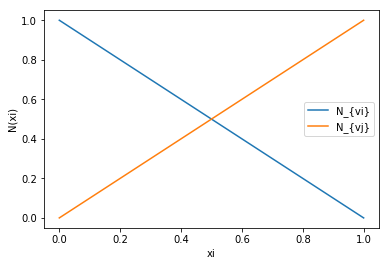

In [25]:
NumberOfPointsToPlot = 50
L=1
xi = np.linspace(0, L, NumberOfPointsToPlot)
plt.figure()
plt.plot(xi, N(xi,L)[0,0,:], label='N_{vi}')
plt.plot(xi, N(xi,L)[0,1,:], label='N_{vj}')

if TypeElement =='Beam2+':
    plt.plot(xi, N(xi,L)[0,-1,:], label='N_{vk}')

if TypeElement == 'Beam3':
    plt.plot(xi, N(xi,L)[0,2,:], label='N_{vk}')
    
plt.xlabel('xi')
plt.ylabel('N(xi)')
plt.legend()

### Interpolation des déformations et contraintes
Pour un élément poutre en flexion basé sur le modèle de Timoshenko, les déformations généralisées utiles sont la courbure de flexion $\chi(x) = \frac{d\theta}{dx}(x)$ et l'angle de glissement des sections droites $\gamma(x) = \frac{dv}{dx}-\theta$.
$$\left[ \begin{matrix} \frac{d\theta}{d\xi} \\  \frac{dv}{d\xi}-\theta \end{matrix} \right] = \left[ \begin{matrix} 0 & 0 & -\frac{1}{L} & \frac{1}{L} \\ -\frac{1}{L} & \frac{1}{L} & -1+\frac{\xi}{L} & -\frac{\xi}{L} \end{matrix} \right] . \left[ \begin{matrix} v_i \\ v_j \\ \theta_i \\ \theta_j \end{matrix} \right] = B(\xi) . q_{el}$$

Pour en déduire le moment fléchissant et l'effort tranchant dans la poutre, il convient d'utiliser la loi de comportement généralisée :

$M_f = EI \chi$ et $T = \mu S \gamma$

où $S$ est la section réduite et $\mu = \frac{E}{2(1+\nu)}$ est le module de cisaillement. 
$$ \left[ \begin{matrix} M_f \\ T \end{matrix} \right] = \underbrace{\left[ \begin{matrix} E I & 0 \\ 0 & \mu S \end{matrix} \right]}_D B(\xi) . q_{el} $$ 

Nous définissons donc les fonction matricielles 'B' et 'StressMatrix' respectivement pour l'interpolation des déformations et des contraintes généralisées (moment fléchissant et effort tranchant).

In [26]:
if TypeElement == 'Beam2':
    def B(xi, L):
        #return : 
        # * chi=dtheta/dx (1rst line) 
        # * gamma=dv/dx-theta (2nd line)
        return  np.array([[     0*xi,     0*xi, -1/L+0*xi, 1/L+0*xi ],
                          [-1/L+0*xi, 1/L+0*xi, -1+xi/L  , -xi/L ]])

elif TypeElement == 'Beam2+':
    def B(xi, L):
        #return : 
        # * chi=dtheta/dx (1rst line) 
        # * gamma=dv/dx-theta (2nd line)
        return  np.array([[     0*xi,     0*xi, -1/L+0*xi, 1/L+0*xi, 0*xi ],
                          [-1/L+0*xi, 1/L+0*xi, -1+xi/L  ,    -xi/L, 4/L*(1-2*xi/L) ]])

elif TypeElement == 'Beam3':
    def B(xi, L):
        #return : 
        # * chi=dtheta/dx (1rst line) 
        # * gamma=dv/dx-theta (2nd line)
        return  np.array([[     0*xi,     0*xi, 0*xi, 4/L**2*xi-3/L, 4/L*(1-2*xi/L), 4/L**2*xi-1/L],
                          [4/L**2*xi-3/L, 4/L*(1-2*xi/L), 4/L**2*xi-1/L, -2/L**2*xi**2+3/L*xi-1, -4/L*xi*(1-xi/L) , -2/L**2*xi**2+1/L*xi]])
    

def StressMatrix(xi, L, x0, E, I, nu, S):
    x = xi+x0 #change of variable: local coordinate is transform into global coordinate to use the function S
    #return flexural moment and shear force  
    #Shear Modulus = 0.5*E/(1+nu)        
    #StressMatrix[0] return the flexural moment
    #StressMatrix[1] return the shear force
    return np.array( [E*I(xi+x0)*B(xi,L)[0],
                      0.5*E/(1+nu)*S(xi+x0)*B(xi,L)[1]])

Remarque : le changement de variable $x = \xi+x_0$ est appliqué au moment quadratique pour passer du repère global au repère élémentaire.

## Matrice de rigidité élémentaire
Pour calculer la matrice de rigidité élémentaire $K_{el}$, il faut revenir à la définition de l'énergie élastique.
Pour des éléments poutres en flexion/cisaillement dans le plan : 
$$E_d = \frac{1}{2} \int_{0}^{L} ( M_f(\xi) \chi(\xi) + T(\xi) \gamma(\xi) ) \, d\xi$$
Et donc en utilisant les interpolations de $\gamma$ et $M_f$ :
$$E_d = q_{el}^T \, \frac{1}{2} \underbrace{\left( \int_{0}^{L} B(\xi,L)^T . D . B(\xi,L) \, d\xi \right)}_{K_{el}} \, q_{el} $$

On commence par définir une fonction pour l'intégration basée sur la méthode des trapèzes dans un soucis de simplicité.

In [27]:
NumberOfIntegrationPoints = 500

def integrate(f, a, b, N):
    x = np.linspace(a, b, N)
    fx = f(x)
    area = np.sum(fx,axis = 0)*(b-a)/N
    return area

Nous avons vu que $K_{el} = \int_{0}^{L} dE(\xi,L,E,I,\nu,S) \, d\xi$
avec $dE = B(\xi,L)^T . D . B(\xi,L)$.

Nous définissons donc la fonction dE que nous intégrons numériquement entre $0$ et $L$.
Ces 2 étapes sont inclus dans la fonction GetElementStiffnessMatrix qui renvoit la matrice de rigidité $K_{el}$.

In [28]:
def GetElementStiffnessMatrix(L, x0, E, I, nu, S, NumberOfIntegrationPoints):
    def dE(xi):        
        Sigma = np.transpose( StressMatrix(xi,L,x0,E,I, nu, S) , (2,1,0) )
        Epsilon = np.transpose( B(xi,L) , (2,0,1) )
        return Sigma @ Epsilon #@ operator = stack of matrix multiplication
    
    return integrate(dE,0,L, NumberOfIntegrationPoints)

Kel = GetElementStiffnessMatrix(L,0,E,I,nu, S, NumberOfIntegrationPoints)
print(Kel)

[[ 3.78641371e+08 -3.78641371e+08  1.89320686e+08  1.89320686e+08]
 [-3.78641371e+08  3.78641371e+08 -1.89320686e+08 -1.89320686e+08]
 [ 1.89320686e+08 -1.89320686e+08  1.36928892e+08  5.23917936e+07]
 [ 1.89320686e+08 -1.89320686e+08  5.23917936e+07  1.36928892e+08]]


In [29]:
Kel = GetElementStiffnessMatrix(L,0,E,I,nu, S, NumberOfIntegrationPoints)
print(Kel)

[[ 3.78641371e+08 -3.78641371e+08  1.89320686e+08  1.89320686e+08]
 [-3.78641371e+08  3.78641371e+08 -1.89320686e+08 -1.89320686e+08]
 [ 1.89320686e+08 -1.89320686e+08  1.36928892e+08  5.23917936e+07]
 [ 1.89320686e+08 -1.89320686e+08  5.23917936e+07  1.36928892e+08]]


## Assemblage de la matrice de rigidité globale

L'assemblage de la matrice globale se fait simplement avec une boucle sur les éléments en ajoutant la contribution de chaque élément aux noeuds correspondants. 

In [30]:
#Assemble the global stiffness matrix
if TypeElement == 'Beam2' or TypeElement == 'Beam3':
    NumberOfDOF = 2*NumberOfNodes #2 dof per node: 2 displacements and 2 rotations
elif TypeElement == 'Beam2+':
    NumberOfDOF = 2*NumberOfNodes + NumberOfElements 
    
StiffnessMatrix = np.zeros((NumberOfDOF, NumberOfDOF)) 
for element in range(NumberOfElements):
    Nodes = ConnectionMatrix[element]  
    Crd = NodeCoordinates[Nodes]
    L = Crd[-1] - Crd[0]    
    x0 = Crd[0]
    if TypeElement == 'Beam2' or TypeElement == 'Beam3':
        DOF = np.hstack((Nodes, Nodes+NumberOfNodes)) #Degree of freedom: 2 displacements and 2 rotations
    elif TypeElement == 'Beam2+':
        DOF = np.hstack((Nodes, Nodes+NumberOfNodes, [2*NumberOfNodes + element])) #Degree of freedom: 2 displacements and 2 rotations
    Kel = GetElementStiffnessMatrix(L,x0,E,I,nu, S, NumberOfIntegrationPoints) 
    StiffnessMatrix[DOF.reshape(-1,1), DOF] += Kel   

print(StiffnessMatrix)

[[ 2.27184823e+08 -2.27184823e+08  0.00000000e+00  0.00000000e+00
   1.89320686e+08  1.89320686e+08  0.00000000e+00  0.00000000e+00]
 [-2.27184823e+08  4.54369646e+08 -2.27184823e+08  0.00000000e+00
  -1.89320686e+08 -2.98023224e-08  1.89320686e+08  0.00000000e+00]
 [ 0.00000000e+00 -2.27184823e+08  4.54369646e+08 -2.27184823e+08
   0.00000000e+00 -1.89320686e+08 -5.96046448e-08  1.89320686e+08]
 [ 0.00000000e+00  0.00000000e+00 -2.27184823e+08  2.27184823e+08
   0.00000000e+00  0.00000000e+00 -1.89320686e+08 -1.89320686e+08]
 [ 1.89320686e+08 -1.89320686e+08  0.00000000e+00  0.00000000e+00
   2.16920276e+08  9.86141999e+07  0.00000000e+00  0.00000000e+00]
 [ 1.89320686e+08 -2.98023224e-08 -1.89320686e+08  0.00000000e+00
   9.86141999e+07  4.33840553e+08  9.86141999e+07  0.00000000e+00]
 [ 0.00000000e+00  1.89320686e+08 -2.98023224e-08 -1.89320686e+08
   0.00000000e+00  9.86141999e+07  4.33840553e+08  9.86141999e+07]
 [ 0.00000000e+00  0.00000000e+00  1.89320686e+08 -1.89320686e+08
   

## Matrice colonne des efforts généralisés


Pour les efforts généralisées, on distingue les efforts ponctuels aux noeuds des efforts linéiques.
On commence par initialiser un vecteur 'ForceVector' contenant uniquement les efforts aux noeuds (ici, un seul effort ponctuel sur le dernier noeuds). 

In [31]:
ForceVector = np.zeros(NumberOfDOF)
ForceVector[NumberOfNodes-1] = F

Pour les efforts linéiques, il faut revenir à la définition du travail des efforts exterieurs sur un élément. 
$$W_{ext} = \int_{0}^{L} f_l(x) v(\xi) \, d\xi$$
Et donc en utilisant l'interpolation de $v(x)$:
$$W_{ext} = q_{el}^T \, \underbrace{\left( \int_{0}^{L} N_v(\xi,L)^T . f_l(\xi+x_0) \, d\xi \right)}_{F_{el}}  $$

Comme pour la matrice de rigidité globale, nous définissons une fonction $dF = N_v(\xi,L)^T . f_l(\xi+x0)$ que nous intégrons sur chaque élément pour avoir $F_{el}$, puis nous sommons les contributions de chaque éléments dans une matrice colonne globale (matrice des efforts généralisés). 

In [32]:
#Assemble force vector
for element in range(NumberOfElements):
    Nodes = ConnectionMatrix[element]   
    Crd = NodeCoordinates[Nodes]
    L = Crd[-1] - Crd[0]
    x0 = Crd[0]

    if TypeElement == 'Beam2' or TypeElement == 'Beam3':
        DOF = np.hstack((Nodes, Nodes+NumberOfNodes)) #Degree of freedom: 2 displacements and 2 rotations
    elif TypeElement == 'Beam2+':
        DOF = np.hstack((Nodes, Nodes+NumberOfNodes, [2*NumberOfNodes + element])) #Degree of freedom: 2 displacements and 2 rotations
    
    def dF(xi):
        return (fl(xi+x0)*N(xi,L)[0]).T
        
    Fel = integrate(dF, 0, L, NumberOfIntegrationPoints)
    ForceVector[DOF] += Fel #[0]  
    
print(ForceVector)

[  9.24070363  55.55555556 111.11111111  74.0926297    0.
   0.           0.           0.        ]


## Conditions aux limites et résolution
On définit une matrice $G$ telle que les conditions aux limites s'écrivent : $G q = Q_d$.
Ici nous avons uniquement le premier noeud (noeud 0) qui est bloqué : $v_0=\theta_0=0$.

In [33]:
G = np.zeros((2,NumberOfDOF))
G[0,0] = G[1, NumberOfNodes] = 1
Qd = np.array([0,0]) 
print(G)
print(Qd)

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]]
[0 0]


On construit ensuite le système à résoudre : $M q = V$. 
Les conditions aux limites sont appliquées avec la méthode des multiplicateurs de Lagrange.

In [34]:
nbCL = np.shape(G)[0]
M = np.block([[StiffnessMatrix, -G.T],[G, np.zeros((nbCL, nbCL))]])
print(M)

[[ 2.27184823e+08 -2.27184823e+08  0.00000000e+00  0.00000000e+00
   1.89320686e+08  1.89320686e+08  0.00000000e+00  0.00000000e+00
  -1.00000000e+00 -0.00000000e+00]
 [-2.27184823e+08  4.54369646e+08 -2.27184823e+08  0.00000000e+00
  -1.89320686e+08 -2.98023224e-08  1.89320686e+08  0.00000000e+00
  -0.00000000e+00 -0.00000000e+00]
 [ 0.00000000e+00 -2.27184823e+08  4.54369646e+08 -2.27184823e+08
   0.00000000e+00 -1.89320686e+08 -5.96046448e-08  1.89320686e+08
  -0.00000000e+00 -0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -2.27184823e+08  2.27184823e+08
   0.00000000e+00  0.00000000e+00 -1.89320686e+08 -1.89320686e+08
  -0.00000000e+00 -0.00000000e+00]
 [ 1.89320686e+08 -1.89320686e+08  0.00000000e+00  0.00000000e+00
   2.16920276e+08  9.86141999e+07  0.00000000e+00  0.00000000e+00
  -0.00000000e+00 -1.00000000e+00]
 [ 1.89320686e+08 -2.98023224e-08 -1.89320686e+08  0.00000000e+00
   9.86141999e+07  4.33840553e+08  9.86141999e+07  0.00000000e+00
  -0.00000000e+00 -0.00000000e+00

In [35]:
V = np.block([ForceVector, Qd])
print(V)

[  9.24070363  55.55555556 111.11111111  74.0926297    0.
   0.           0.           0.           0.           0.        ]


le système est résolu par une méthode directe (pivot de Gauss). Pour les grands systèmes creux, l'utilisation d'une méthode itérative est en général plus efficace. 

In [36]:
nbCL = np.shape(G)[0]
M = np.block([[StiffnessMatrix, -G.T],[G, np.zeros((nbCL, nbCL))]])
print(M)
V = np.block([ForceVector, Qd])
print(V)

res  = np.linalg.solve(M, V)
U = res[:NumberOfNodes]
Theta= res[NumberOfNodes:2*NumberOfNodes]
R = res[2*NumberOfNodes:]
print(U) #Nodal displacement
print(Theta) #Nodal rotation 
print(R) #Force and Moment Reaction

[[ 2.27184823e+08 -2.27184823e+08  0.00000000e+00  0.00000000e+00
   1.89320686e+08  1.89320686e+08  0.00000000e+00  0.00000000e+00
  -1.00000000e+00 -0.00000000e+00]
 [-2.27184823e+08  4.54369646e+08 -2.27184823e+08  0.00000000e+00
  -1.89320686e+08 -2.98023224e-08  1.89320686e+08  0.00000000e+00
  -0.00000000e+00 -0.00000000e+00]
 [ 0.00000000e+00 -2.27184823e+08  4.54369646e+08 -2.27184823e+08
   0.00000000e+00 -1.89320686e+08 -5.96046448e-08  1.89320686e+08
  -0.00000000e+00 -0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -2.27184823e+08  2.27184823e+08
   0.00000000e+00  0.00000000e+00 -1.89320686e+08 -1.89320686e+08
  -0.00000000e+00 -0.00000000e+00]
 [ 1.89320686e+08 -1.89320686e+08  0.00000000e+00  0.00000000e+00
   2.16920276e+08  9.86141999e+07  0.00000000e+00  0.00000000e+00
  -0.00000000e+00 -1.00000000e+00]
 [ 1.89320686e+08 -2.98023224e-08 -1.89320686e+08  0.00000000e+00
   9.86141999e+07  4.33840553e+08  9.86141999e+07  0.00000000e+00
  -0.00000000e+00 -0.00000000e+00

## Visualisation
### Visualisation du déplacement


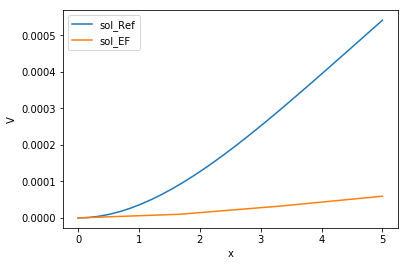

In [37]:
#Reference solution (only for constant section)
x = np.linspace(0, H, 10*NumberOfElements)
if LoadCondition == 0:
    plt.plot(x, fl(x)*((H-x)**4 + 4*H**3*x-H**4)/(24*E*I(x)), label='sol_Ref')
#elif LoadCondition == 1:
#    plt.plot(x, fl(x)*x**2*(20*H**3-10*H**2*x+x**3)/(120*E*I(x)*H), label='sol_Ref')
elif LoadCondition == 1:
    a = (fl(H)-fl(0))/H ; b = fl(0)
    plt.plot(x, (a/120*x**5 + b/24*x**4 - (a*H**2/12+b*H/6)*x**3 + (a*H**3/6 + b*H**2/4)*x**2)/(E*I(x)), label='sol_Ref')
elif LoadCondition == 2: 
    plt.plot(x, F*x**2*(3*H-x)/(6*E*I(x)), label='sol_Ref')

#FE solution
xi = np.linspace(0, L, 10)
x_all = []
u_y = []
for element in range(NumberOfElements):
    Nodes = ConnectionMatrix[element] 
    if TypeElement == 'Beam2' or TypeElement == 'Beam3':
        DOF = np.hstack((Nodes, Nodes+NumberOfNodes)) #Degree of freedom: 2 displacements and 2 rotations
    elif TypeElement == 'Beam2+':
        DOF = np.hstack((Nodes, Nodes+NumberOfNodes, [2*NumberOfNodes + element])) #Degree of freedom: 2 displacements and 2 rotations
    Crd = NodeCoordinates[Nodes]
    L = Crd[-1]-Crd[0]
    x = np.linspace(Crd[0], Crd[-1], 10)
    u_y = np.hstack((u_y, (N(xi, L).transpose(2,0,1)@res[DOF])[:,0]))
    x_all = np.hstack((x_all, x))

plt.plot(x_all, u_y, label='sol_EF')
plt.xlabel('x')
plt.ylabel('V')
plt.legend()


### Visualisation de l'effort normal

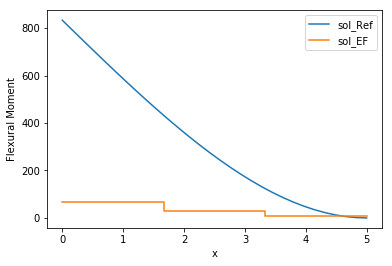

In [38]:
#Reference solution (only for constant section)
x = np.linspace(0, H, 10*NumberOfElements)
if LoadCondition == 0:
    plt.plot(x, fl(x)*12*(H-x)**2/24, label='sol_Ref')
       
elif LoadCondition == 1:
    a = (fl(H)-fl(0))/H ; b = fl(0)
    plt.plot(x, a/3*(H**3-x**3) + (b-a*x)/2*(H**2-x**2) - x*b*(H-x), label='sol_Ref')

elif LoadCondition == 2: 
    plt.plot(x, F*(H-x) , label='sol_Ref')


#FE solution
xi = np.linspace(0, L, 10)
x_all = []
sigma_x = []
for element in range(NumberOfElements):
    Nodes = ConnectionMatrix[element]   
    if TypeElement == 'Beam2' or TypeElement == 'Beam3':
        DOF = np.hstack((Nodes, Nodes+NumberOfNodes)) #Degree of freedom: 2 displacements and 2 rotations
    elif TypeElement == 'Beam2+':
        DOF = np.hstack((Nodes, Nodes+NumberOfNodes, [2*NumberOfNodes + element])) #Degree of freedom: 2 displacements and 2 rotations
    Crd = NodeCoordinates[Nodes]
    L = Crd[-1]-Crd[0]
    x0 = Crd[0]
    x = np.linspace(Crd[0], Crd[-1], 10)
    sigma_x = np.hstack((sigma_x, (StressMatrix(xi, L,x0,  E, I, nu, S).transpose(2,0,1)@res[DOF])[:,0]))
    x_all = np.hstack((x_all, x))

plt.plot(x_all, sigma_x, label='sol_EF')
plt.xlabel('x')
plt.ylabel('Flexural Moment')
plt.legend()

[ 2266.02929609  1815.96929615  1365.90929622   915.84929628
   465.78929634    15.7292964   -434.33070354  -884.39070348
 -1334.45070341 -1784.51070335]
[1074.38650075  876.79033188  679.194163    481.59799413  284.00182525
   86.40565638 -111.1905125  -308.78668137 -506.38285025 -703.97901912]
[ 271.70529517  227.79136951  183.87744385  139.96351819   96.04959253
   52.13566687    8.22174121  -35.69218444  -79.6061101  -123.52003576]


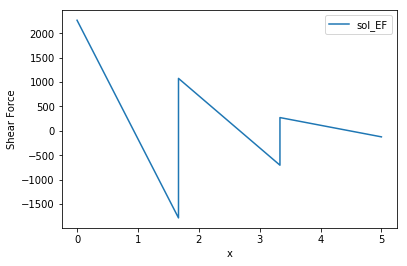

In [39]:
#FE solution
xi = np.linspace(0, L, 10)
x_all = []
sigma_xy = []
for element in range(NumberOfElements):
    Nodes = ConnectionMatrix[element]   
    if TypeElement == 'Beam2' or TypeElement == 'Beam3':
        DOF = np.hstack((Nodes, Nodes+NumberOfNodes)) #Degree of freedom: 2 displacements and 2 rotations
    elif TypeElement == 'Beam2+':
        DOF = np.hstack((Nodes, Nodes+NumberOfNodes, [2*NumberOfNodes + element])) #Degree of freedom: 2 displacements and 2 rotations
    Crd = NodeCoordinates[Nodes]
    L = Crd[-1]-Crd[0]
    x0 = Crd[0]
    x = np.linspace(Crd[0], Crd[-1], 10)
    sigma_xy = np.hstack((sigma_xy, (StressMatrix(xi, L,x0,  E, I, nu, S).transpose(2,0,1)@res[DOF])[:,1]))
    print((StressMatrix(xi, L,x0,  E, I, nu, S).transpose(2,0,1)@res[DOF])[:,1])

    x_all = np.hstack((x_all, x))

plt.plot(x_all, sigma_xy, label='sol_EF')
plt.xlabel('x')
plt.ylabel('Shear Force')
plt.legend()
    
    

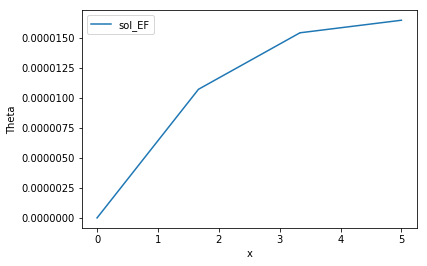

In [40]:
xi = np.linspace(0, L, 10)
x_all = []
theta_x = []
for element in range(NumberOfElements):
    Nodes = ConnectionMatrix[element] 
    if TypeElement == 'Beam2':
        DOF = np.hstack((Nodes, Nodes+NumberOfNodes)) #Degree of freedom: 2 displacements and 2 rotations
    elif TypeElement == 'Beam2+':
        DOF = np.hstack((Nodes, Nodes+NumberOfNodes, [2*NumberOfNodes + element])) #Degree of freedom: 2 displacements and 2 rotations
    Crd = NodeCoordinates[Nodes]
    L = Crd[-1]-Crd[0]
    x = np.linspace(Crd[0], Crd[-1], 10)
    theta_x = np.hstack((theta_x, (N(xi, L).transpose(2,0,1)@res[DOF])[:,1]))
    x_all = np.hstack((x_all, x))

plt.plot(x_all, theta_x, label='sol_EF')
plt.xlabel('x')
plt.ylabel('Theta')
plt.legend()

## Pour aller plus loin
* Modifier le nombre de noeuds et relancer le calcul pour observer la convergence des résultats vers la solution analytique. On remarque que le résultat de l'effort tranchant n'est pas satisfaisant.
* Changer pour l'élément 'Beam3' à 3 noeuds et observer les résultats. La convergence de la flèche et du moment fléchissant est améliorée mais l'effort tranchant et l'évolution de l'angle de rotation de section ne sont toujours pas bien approchés. On peut donc conclure qu'augmenter l'ordre de l'interpolation ne conduit pas toujours à une meilleur approximation.
* Changer pour l'élément 'Beam2+' et observer les résultats. On voit clairement une amélioration sur l'approximation de l'effort tranchant. Comme la flexion est dominante dans ce problème, l'angle de glissement sera très petit. Dans l'expression de l'angle de glissement, nous voyons donc que la dérivée de $v$ sera proche de $\theta$. Il est donc souhaitable d'utiliser une interpolation d'ordre plus élevé pour $v$ que pour $\theta$. L'élément 'Beam2+' est construit de sur la base d'une interpolation linéaire pour $v$ et $\theta$ mais on rajoute un degré de liberté supplémentaire pour enrichir l'interpolation de $v$. La fonction de forme associée à ce degré de liberté est quadratique, vaut 1 au centre (en $\frac{L}{2}$) et s'annule sur les bords de l'élément. Il est bien sur aussi possible de construire une interpolation quadratique pour $v$ et affine pour $\theta$. 